# DeconvNet

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from sklearn.metrics import f1_score

import tensorflow as tf


In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

def normalize_data(data):
    # Data pre-processing, Normalize each image with itself
    n = data.shape[0]
    for i in range(n):
        xx = data[i,:,:]
        xx -= np.mean(xx) # Centering in 0
        xx /= np.linalg.norm(xx) # Normalizing to 1
        data[i] = xx # Affect value
    return data
def one_hot_convert(vector, num_classes=None):
    """ (From https://stackoverflow.com/questions/29831489/numpy-1-hot-array)
    Converts an input 1-D vector of integers into an output
    2-D array of one-hot vectors, where an i'th input value
    of j will set a '1' in the i'th row, j'th column of the
    output array.

    Example:
        v = np.array((1, 0, 4))
        one_hot_v = convertToOneHot(v)
        print one_hot_v

        [[0 1 0 0 0]
         [1 0 0 0 0]
         [0 0 0 0 1]]
    """

    assert isinstance(vector, np.ndarray)
    assert len(vector) > 0

    if num_classes is None:
        num_classes = np.max(vector)+1
    else:
        assert num_classes > 0
        assert num_classes >= np.max(vector)

    result = np.zeros(shape=(len(vector), num_classes))
    result[np.arange(len(vector)), vector] = 1
    return result

In [3]:
a=np.asarray([[1,2,3],[4,5,6],[7,8,9]])
a[2:,:]

array([[7, 8, 9]])

In [4]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
#n = len(files)
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

#n = int(len(files)*0.8) # Only use 10 images for training
n=10
np_imgs = normalize_data(np.asarray(imgs))
train_imgs = np_imgs[:n]
val_imgs = np_imgs[n:]
np_gt = np.ceil(np.asarray(gt_imgs))
train_gt = np_gt[:n]
val_gt = np_gt[n:]

Loading 20 images
satImage_001.png
Loading 20 images
satImage_001.png


In [5]:
def unpool(net, mask, stride):
  assert mask is not None
  with tf.name_scope('UnPool2D'):
    ksize = [1, stride, stride, 1]
    input_shape = net.get_shape().as_list()
    #  calculation new shape
    output_shape = (input_shape[0], input_shape[1] * ksize[1], input_shape[2] * ksize[2], input_shape[3])
    # calculation indices for batch, height, width and feature maps
    one_like_mask = tf.ones_like(mask)
    batch_range = tf.reshape(tf.range(output_shape[0], dtype=tf.int64), shape=[input_shape[0], 1, 1, 1])
    b = one_like_mask * batch_range
    y = mask // (output_shape[2] * output_shape[3])
    x = mask % (output_shape[2] * output_shape[3]) // output_shape[3]
    feature_range = tf.range(output_shape[3], dtype=tf.int64)
    f = one_like_mask * feature_range
    # transpose indices & reshape update values to one dimension
    updates_size = tf.size(net)
    indices = tf.transpose(tf.reshape(tf.stack([b, y, x, f]), [4, updates_size]))
    values = tf.reshape(net, [updates_size])
    ret = tf.scatter_nd(indices, values, output_shape)
    return ret

def unpool_naive(value, name='unpool'):
        """N-dimensional version of the unpooling operation from
        https://www.robots.ox.ac.uk/~vgg/rg/papers/Dosovitskiy_Learning_to_Generate_2015_CVPR_paper.pdf

        :param value: A Tensor of shape [b, d0, d1, ..., dn, ch]
        :return: A Tensor of shape [b, 2*d0, 2*d1, ..., 2*dn, ch]
        # x will become [[x,0], [0, 0]] in any cases
        # From : https://github.com/tensorflow/tensorflow/issues/2169
        """
        with tf.name_scope(name) as scope:
            sh = value.get_shape().as_list()
            dim = len(sh[1:-1])
            out = (tf.reshape(value, [-1] + sh[-dim:]))
            for i in range(dim, 0, -1):
                out = tf.concat( [out, tf.zeros_like(out, dtype=tf.float32)],i)
            out_size = [-1] + [s * 2 for s in sh[1:-1]] + [sh[-1]]
            out = tf.reshape(out, out_size, name=scope)
        return out
    
def get_bilinear_filter(filter_shape, upscale_factor):
    """http://cv-tricks.com/image-segmentation/transpose-convolution-in-tensorflow/"""
    ##filter_shape is [width, height, num_in_channels, num_out_channels]
    kernel_size = filter_shape[1]
    ### Centre location of the filter for which value is calculated
    if kernel_size % 2 == 1:
        centre_location = upscale_factor - 1
    else:
        centre_location = upscale_factor - 0.5
 
    bilinear = np.zeros([filter_shape[0], filter_shape[1]])
    for x in range(filter_shape[0]):
        for y in range(filter_shape[1]):
            ##Interpolation Calculation
            value = (1 - abs((x - centre_location)/ upscale_factor)) * (1 - abs((y - centre_location)/ upscale_factor))
            bilinear[x, y] = value
    weights = np.zeros(filter_shape)
    for i in range(filter_shape[2]):
        weights[:, :, i, i] = bilinear
    init = tf.constant_initializer(value=weights,
                                       dtype=tf.float32)
 
    bilinear_weights = tf.get_variable(name="deconv_bilinear_filter", initializer=init,
                               shape=weights.shape)
    return bilinear_weights
    
def upsample_layer(bottom, n_channels, name, upscale_factor):
    """http://cv-tricks.com/image-segmentation/transpose-convolution-in-tensorflow/"""
    kernel_size = 2*upscale_factor - upscale_factor%2
    stride = upscale_factor   
    strides = [1, stride, stride, 1]
    with tf.variable_scope(name):
        # Shape of the bottom tensor
        in_shape = tf.shape(bottom)
 
        h = ((in_shape[1] - 1) * stride) + 1
        w = ((in_shape[2] - 1) * stride) + 1
        new_shape = [in_shape[0], h, w, n_channels]
        output_shape = tf.stack(new_shape)
 
        filter_shape = [kernel_size, kernel_size, n_channels, n_channels]
 
        weights = get_bilinear_filter(filter_shape,upscale_factor)
        deconv = tf.nn.conv2d_transpose(bottom, weights, output_shape,
                                            strides=strides, padding='SAME')
 
    return deconv

def deconv_layer(x, W_shape, b_shape, padding='SAME'):
    """https://github.com/fabianbormann/Tensorflow-DeconvNet-Segmentation/blob/master/DeconvNetPipeline.py
    W_shape must be [width height in_channel out_channel]"""
    
    W = tf.Variable(tf.truncated_normal(W_shape,stddev=0.1))
    b = tf.Variable(tf.constant(0.1, shape=[b_shape]))
    x_shape = tf.shape(x)
    out_shape = tf.stack([x_shape[0], x_shape[1], x_shape[2], W_shape[2]])

    return tf.nn.conv2d_transpose(x, W, out_shape, [1, 1, 1, 1], padding=padding) + b

def weighted_pixelwise_crossentropy(y_true, y_pred, class_weights):
    """computes pixelwise crossentropy"""
    temp = tf.clip_by_value(y_pred, 1e-8, 1. - 1e-8)
    loss = - tf.reduce_sum(tf.multiply(y_true * tf.log(temp), class_weights))
    return loss

In [6]:
# Define neural network

learning_rate = 1e0
reg = 1e-3
n_filters = 16
kernel_size = 5

tf_data = tf.placeholder(tf.float32,[None, 400,400,3])
tf_labels = tf.placeholder(tf.int32,[None,2])
keep_prob = tf.placeholder(tf.float32)
regularizer = tf.contrib.layers.l2_regularizer(scale=reg)

class_weights = tf.constant([[1.0,3.0]])
weights = tf.reduce_sum(class_weights * tf.cast(tf_labels, tf.float32), axis=1)

#Conv layer 1
conv_1 = tf.layers.conv2d(inputs=tf_data, filters=n_filters, kernel_size=kernel_size, kernel_regularizer=regularizer, bias_regularizer=regularizer, padding='same')
#pool layer 1
print("conv1 size", conv_1.shape)

pool_1 = tf.contrib.layers.max_pool2d(inputs = conv_1, kernel_size=2, stride=2)
#pool_1, mask_1 = tf.nn.max_pool_with_argmax(input=conv_1, ksize=(1,2,2,1), strides=(1,2,2,1), padding='VALID')
print("pool1 size", pool_1.shape)

#conv layer 2

conv_2 = tf.layers.conv2d(inputs = pool_1, filters = n_filters*2, kernel_size = kernel_size, kernel_regularizer=regularizer, bias_regularizer=regularizer, padding='same')
print("conv2 size", conv_2.shape)

#Pool layer 2

pool_2 = tf.contrib.layers.max_pool2d(inputs = conv_2, kernel_size=2, stride=2)
#pool_2, mask_2 = tf.nn.max_pool_with_argmax(input=conv_2, ksize=(1,2,2,1), strides=(1,2,2,1), padding='VALID')

print("pool2 size", pool_2.shape)

# Relu

relu_1 = tf.nn.relu(features=pool_2)

#Conv layer 3
conv_3 = tf.layers.conv2d(inputs=relu_1, filters=n_filters*4, kernel_size=kernel_size, kernel_regularizer=regularizer, bias_regularizer=regularizer, padding='same')
#pool layer 3
print("conv3 size", conv_3.shape)

pool_3 = tf.contrib.layers.max_pool2d(inputs = conv_3, kernel_size=2, stride=2)
#pool_3, mask_3 = tf.nn.max_pool_with_argmax(input=conv_3, ksize=(1,2,2,1), strides=(1,2,2,1), padding='VALID')

print("pool3 size", pool_3.shape)

#conv layer 4

conv_4 = tf.layers.conv2d(inputs = pool_3, filters = n_filters*4, kernel_size = kernel_size, kernel_regularizer=regularizer, bias_regularizer=regularizer, padding='same')
print("conv4 size", conv_4.shape)

#Pool layer 4

pool_4 = tf.contrib.layers.max_pool2d(inputs = conv_4, kernel_size=2, stride=2)
#pool_4, mask_4 = tf.nn.max_pool_with_argmax(input=conv_4, ksize=(1,2,2,1), strides=(1,2,2,1), padding='VALID')

print("pool4 size", pool_4.shape)

# Relu 2

relu_2 = tf.nn.relu(features=pool_4)

#FC layer (as conv)
#fc_1 = tf.layers.conv2d(inputs= relu_2, kernel_size=(25,25), filters = 500, kernel_regularizer=regularizer,bias_regularizer=regularizer) #compute the shape based on the expected input (here 200 => 15x15)
#print("fc1 size ", fc_1.shape)
#FC Layer 2 (as conv)
#fc_2 = tf.layers.conv2d(inputs=fc_1, kernel_size = 1, filters=2, kernel_regularizer=regularizer,bias_regularizer=regularizer)
#print("fc2 size ", fc_2.shape)
#fc_1 = tf.contrib.layers.fully_connected(inputs=tf.reshape(conv_out,[-1, (mfcc_num-kernel_size+1)*n_filters]), num_outputs=2, weights_regularizer=regularizer, biases_regularizer=regularizer)
#fc_1 = tf.layers.dropout(inputs=fc_1,rate=keep_prob)

# Deconv FC layer
#deconv_fc = deconv_layer(fc_2, [25,25,100,2],100)
#deconv_fc = tf.layers.conv2d_transpose(inputs=fc_1, kernel_size=(25,25), filters = n_filters*4, kernel_regularizer=regularizer,bias_regularizer=regularizer)
#deconv_fc = upsample_layer(bottom=fc_2, n_channels=64, name="deconv_fc", upscale_factor=25)
#print("deconv fc size ", deconv_fc.shape)

# Deconv relu

#relu_3 = tf.nn.relu(features=deconv_fc)
# Unpool 1
unpool_1 = unpool_naive(relu_2)
print("unpool 1 size", unpool_1.shape)

# Deconv 1

deconv_1 = tf.layers.conv2d_transpose(inputs=unpool_1, filters=n_filters*4 ,kernel_size=kernel_size, kernel_regularizer=regularizer,bias_regularizer=regularizer,padding='SAME')
print("deconv_1 size ",deconv_1.shape)

# Unpool 2

unpool_2 = unpool_naive(deconv_1)
print("unpool2 size ", unpool_2.shape)

#Deconv 2

deconv_2 = tf.layers.conv2d_transpose(inputs=unpool_2, filters=n_filters*2,kernel_size=kernel_size, kernel_regularizer=regularizer,bias_regularizer=regularizer,padding='SAME')
print("deconv_2 size", deconv_2.shape)

#unpool 3 

unpool_3 = unpool_naive(deconv_2)
print("unpool3 size ", unpool_3.shape)

#Deconv 3

deconv_3 = tf.layers.conv2d_transpose(inputs=unpool_3, filters=n_filters,kernel_size=kernel_size, kernel_regularizer=regularizer,bias_regularizer=regularizer,padding='SAME')
print("deconv_3 size", deconv_3.shape)

#unpool 4

unpool_4 = unpool_naive(deconv_3)
print("unpool4 size ", unpool_4.shape)

#Deconv 4

#deconv_4 = tf.layers.conv2d_transpose(inputs=unpool_4, filters=3,kernel_size=kernel_size, kernel_regularizer=regularizer,bias_regularizer=regularizer,padding='SAME')
#print("deconv_4 size", deconv_4.shape)

# Score

score_layer = tf.layers.conv2d_transpose(inputs=unpool_4, filters=2, kernel_size=1, kernel_regularizer=regularizer,bias_regularizer=regularizer, padding='SAME')
print("score size", score_layer.shape)

logits = tf.reshape(score_layer, (-1,2))

print(logits)
print(tf_labels)
#loss
#cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_labels, logits=logits)
#cross_entropy = tf.losses.softmax_cross_entropy(tf_labels, logits,weights=weights)
#cross_entropy = tf.losses.sigmoid_cross_entropy(tf_labels, logits, weights=class_weights)
cross_entropy = weighted_pixelwise_crossentropy(tf.cast(tf_labels, dtype=tf.float32), logits, class_weights)
#Regularization
reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
reg_term = tf.contrib.layers.apply_regularization(regularizer, reg_variables)
loss = reg_term + cross_entropy

#Optimizer
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

preds = tf.argmax(logits,axis=1,output_type=tf.int32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(preds, tf.argmax(tf_labels,axis=1, output_type=tf.int32)), tf.float32))


conv1 size (?, 400, 400, 16)
pool1 size (?, 200, 200, 16)
conv2 size (?, 200, 200, 32)
pool2 size (?, 100, 100, 32)
conv3 size (?, 100, 100, 64)
pool3 size (?, 50, 50, 64)
conv4 size (?, 50, 50, 64)
pool4 size (?, 25, 25, 64)
unpool 1 size (?, 50, 50, 64)
deconv_1 size  (?, 50, 50, 64)
unpool2 size  (?, 100, 100, 64)
deconv_2 size (?, 100, 100, 32)
unpool3 size  (?, 200, 200, 32)
deconv_3 size (?, 200, 200, 16)
unpool4 size  (?, 400, 400, 16)
score size (?, 400, 400, 2)
Tensor("Reshape:0", shape=(?, 2), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 2), dtype=int32)


In [7]:
n_epoch = 2

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for epoch in range(n_epoch):
    train_idx = np.random.permutation(np.arange(n))
    for idx in train_idx:
        print("training on image {:d}".format(idx))
        cur_img = train_imgs[idx]

        batch_x = np.expand_dims(cur_img,axis=0)
        batch_y = one_hot_convert(np.reshape(train_gt[idx],(400*400)).astype(int),2)
        
        _, train_acc, train_loss, train_cross_entropy, train_reg_term = sess.run([train_step, accuracy, loss, cross_entropy, reg_term], feed_dict={tf_data : batch_x, tf_labels : batch_y})
        print(train_cross_entropy)
        print(train_reg_term)
    if epoch % 1 ==0:
        train_pred, train_acc, train_loss = sess.run([preds, accuracy, loss], feed_dict={tf_data : train_imgs, tf_labels : one_hot_convert(np.reshape(train_gt,n*400*400).astype(int),2)})
        val_pred, val_acc, val_loss = sess.run([preds, accuracy, loss], feed_dict={tf_data : val_imgs, tf_labels : one_hot_convert(np.reshape(val_gt,n*400*400).astype(int),2)})
        
        print(train_pred.shape)
        print(val_pred.shape)
        print(train_gt.shape)
        f1_train = f1_score(np.reshape(train_gt,n*400*400), train_pred, average='macro') 
        f1_val = f1_score(np.reshape(val_gt,n*400*400), val_pred, average='macro')
        print("epoch ", epoch+1,", val f1 : ", f1_val, ", train f1 : ", f1_train)
        print("val_loss : ", val_loss, ", train_loss : ", train_loss)

training on image 7
4.07449e+06
1.60687e-06
training on image 4
527735.0
3.31609
training on image 8
415108.0
25.7737
training on image 6
390091.0
75.897
training on image 9
372427.0
154.193
training on image 0
343561.0
257.906
training on image 2
344059.0
383.136
training on image 5
343710.0
525.634
training on image 1
342107.0
681.297
training on image 3
327886.0
846.36
(1600000,)
(1600000,)
(10, 400, 400)
epoch  1 , val f1 :  0.500416277578 , train f1 :  0.492865112369
val_loss :  3.0621e+06 , train_loss :  3.31668e+06
training on image 3
325067.0
1017.45
training on image 6
329065.0
1191.66
training on image 9
326284.0
1366.52
training on image 7
315268.0
1539.96
training on image 0
312542.0
1710.31
training on image 8
329525.0
1876.21
training on image 2
322691.0
2036.62
training on image 4
317258.0
2190.75
training on image 1
321384.0
2338.02
training on image 5
323503.0
2478.05
(1600000,)
(1600000,)
(10, 400, 400)
epoch  2 , val f1 :  0.500403679655 , train f1 :  0.49278605868
v

In [8]:
print(train_gt.shape)
print(val_gt.shape)

(10, 400, 400)
(10, 400, 400)


In [9]:
print(np.reshape(val_pred, val_gt.shape))
print(val_gt)

[[[1 0 1 ..., 0 1 0]
  [0 0 0 ..., 0 0 0]
  [1 0 1 ..., 0 1 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [1 0 1 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]

 [[1 0 1 ..., 0 1 0]
  [0 0 0 ..., 0 0 0]
  [1 0 1 ..., 0 1 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [1 0 1 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]

 [[1 0 1 ..., 0 1 0]
  [0 0 0 ..., 0 0 0]
  [1 0 1 ..., 0 1 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [1 0 1 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]

 ..., 
 [[1 0 1 ..., 0 1 0]
  [0 0 0 ..., 0 0 0]
  [1 0 1 ..., 0 1 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [1 0 1 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]

 [[1 0 1 ..., 0 1 0]
  [0 0 0 ..., 0 0 0]
  [1 0 1 ..., 0 1 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [1 0 1 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]

 [[1 0 1 ..., 0 1 0]
  [0 0 0 ..., 0 0 0]
  [1 0 1 ..., 0 1 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [1 0 1 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]]
[[[ 1.  1.  1. ...,  1.  1.  1.]
  [ 1.  1.  1. ...,  1.  1.  1.]
  [ 1.  1.  1. ...,  1.  1.  1.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 

In [10]:
1/np.mean(np_gt[-1])

7.7904368360284373

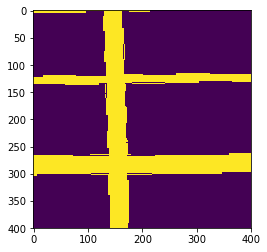

In [11]:
plt.imshow(val_gt[1,:])

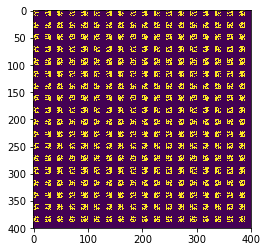

In [12]:
test = np.reshape(val_pred, val_gt.shape)
plt.imshow(test[1,:])